# IEEE Dataset

In [1]:
import os
import pathlib
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import torch

data_dir = "../../backup_datasets/IEEE"
target_dir = "../../IEEE"

adhd_data_dir = [
    os.path.join(data_dir, "ADHD_part1"),
    os.path.join(data_dir, "ADHD_part2"),
]
control_data_dir = [
    os.path.join(data_dir, "Control_part1"),
    os.path.join(data_dir, "Control_part2"),
]

In [2]:
def mat2numpy(file) -> np.ndarray:
    mat = scipy.io.loadmat(str(file))
    signal = mat[file.stem]
    return signal


def to_all_data_in(dir: str, func, dtype=np.int32):
    """Execute function on all data in a directory

    :param dir: directory to search for data files
    :param func: function to execute on data(np.ndarray)
    :param dtype: data type (default: int32)
    """
    returns = []
    data_path = pathlib.Path(dir)
    for file in data_path.iterdir():
        if file.is_file():
            ret = mat2numpy(file).astype(dtype)
            ret = func(ret)
            returns.append(ret)
    return returns

## Visualize

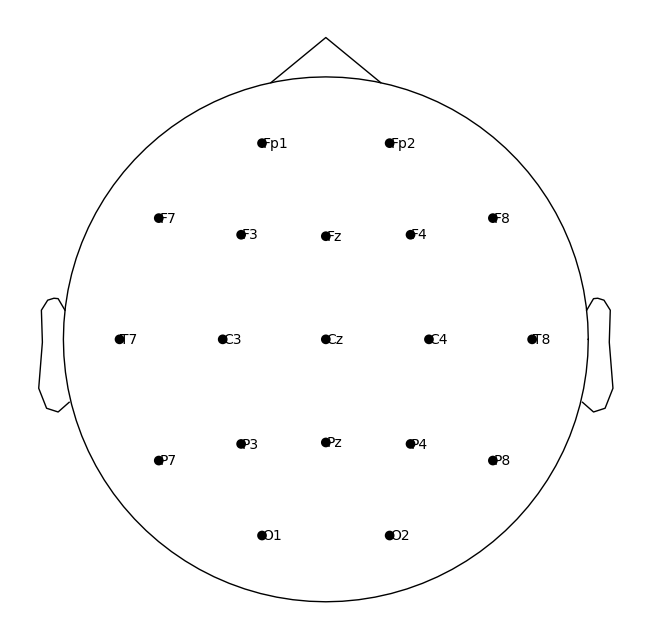

In [3]:
ced_file = data_dir + "/Standard-10-20-Cap19new.ced"
df = pd.read_csv(ced_file, sep="\t")

electrode_data = df[["labels", "X", "Y", "Z"]]

ch_pos = {
    row["labels"]: [-row["Y"], row["X"], row["Z"]]
    for _, row in electrode_data.iterrows()
}

montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame="head")
montage.plot(sphere=1.3)
plt.show()

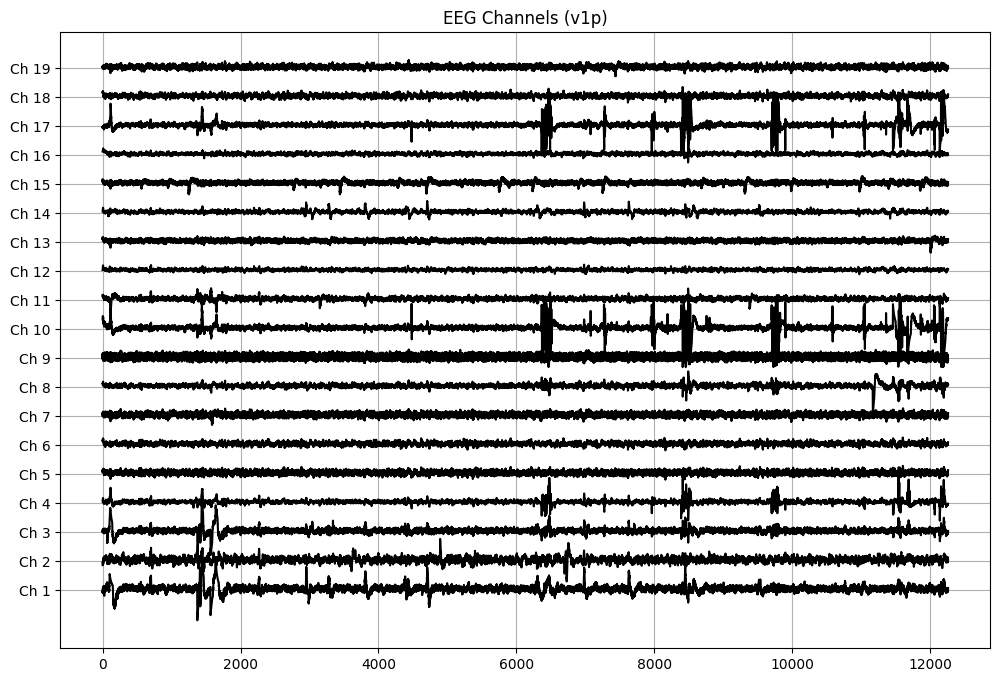

In [4]:
sample_mat_file = pathlib.Path(data_dir + "/ADHD_part1/v1p.mat")
signal = mat2numpy(sample_mat_file).astype(np.int32)
time_vector = np.arange(1, 12259)

plt.figure(figsize=(12, 8))
offset = 3000

for ch in range(signal.shape[1]):
    plt.plot(time_vector, signal[:, ch] + (ch + 1) * offset, "k")

plt.title("EEG Channels (v1p)")
plt.yticks(offset * (np.arange(19) + 1))

ax = plt.gca()
ax.set_yticklabels([f"Ch {i+1}" for i in range(19)])

plt.grid(True)
plt.show()

## Size

In [5]:
def get_length(arr: np.ndarray):
    return arr.shape[0]


def verify(arr: np.ndarray):
    assert np.array_equal(arr.astype(np.int64), arr.astype(np.int32))
    return arr

In [6]:
data_lens_adhd = []
for adhd_dir in adhd_data_dir:
    data_len = to_all_data_in(adhd_dir, get_length)
    data_lens_adhd += data_len

print("min length:", min(data_lens_adhd))
print("max length:", max(data_lens_adhd))
print("# of samples:", len(data_lens_adhd))

min length: 9286
max length: 43252
# of samples: 61


In [7]:
data_lens_control = []
for control_dir in control_data_dir:
    data_len = to_all_data_in(control_dir, get_length)
    data_lens_control += data_len

print("min length:", min(data_lens_control))
print("max length:", max(data_lens_control))
print("# of samples:", len(data_lens_control))

min length: 7983
max length: 25985
# of samples: 60


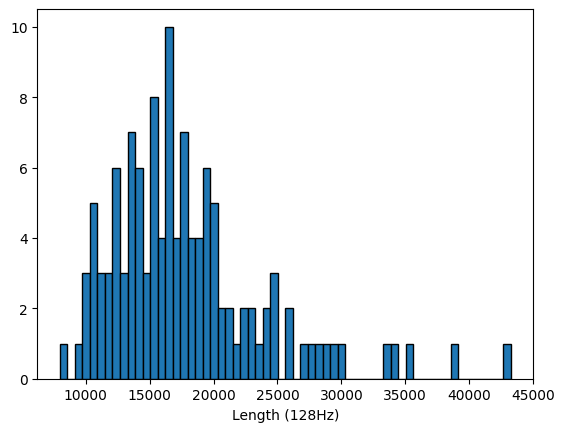

In [8]:
plt.hist(np.array(data_lens_adhd + data_lens_control), bins=60, edgecolor="black")
plt.xlabel("Length (128Hz)")
plt.show()

Since data length varies, we need to make it uniform. This is done by dividing the data into subsets of 2560 (20ms * 128Hz)

## Preprocess

In [9]:
subset_len = 20 * 128


def get_subsets(arr: np.ndarray):
    subsets = []
    for i in range(0, arr.shape[0] - subset_len, subset_len):
        subset = arr[i : i + subset_len]
        subsets.append(subset)
    return subsets

Convert data to torch tensor(int32) and add to list

In [10]:
data_adhd_list = []
data_control_list = []

for adhd_dir in adhd_data_dir:
    file_data = to_all_data_in(adhd_dir, get_subsets)
    for subsets in file_data:
        for subset in subsets:
            data_adhd_list.append(torch.from_numpy(subset))

adhd_dataset = torch.stack(data_adhd_list, dim=0)
print("ADHD subsets:", adhd_dataset.size())

for control_dir in control_data_dir:
    file_data = to_all_data_in(control_dir, get_subsets)
    for subsets in file_data:
        for subset in subsets:
            data_control_list.append(torch.from_numpy(subset))

control_dataset = torch.stack(data_control_list, dim=0)
print("Control subsets:", control_dataset.size())

ADHD subsets: torch.Size([438, 2560, 19])
Control subsets: torch.Size([345, 2560, 19])


In [11]:
torch.save(adhd_dataset, os.path.join(target_dir, "ieee_eeg_adhd.pt"))
torch.save(control_dataset, os.path.join(target_dir, "ieee_eeg_control.pt"))